## Can XGBoost be used to predict time series?
in this notebook I want to explore the idea to use XGBoost algorithm to predict some time series. I will encode the time variable into features usable for the algorithm. The date will be split into `day_of_the_month`, `day_of_the_week`, `week_of_the_year`, `year` and see if that can be used to predict the output variable. This approach will be compare with a more traditional arima model for time series prediction.

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import seaborn as sns
from matplotlib import pyplot
from sklearn import metrics
from tqdm import tqdm, tqdm_notebook

In [2]:
pyplot.rcParams['figure.figsize'] = [20, 10]
pyplot.rcParams["font.size"] = 18

First download the data

In [ ]:
!wget wget https://raw.githubusercontent.com/facebook/prophet/master/examples/example_wp_log_peyton_manning.

get the second dataset [here](https://www.kaggle.com/robikscube/hourly-energy-consumption#PJME_hourly.csv) (Kaggle).

Load it

In [3]:
df = pd.read_csv('example_wp_log_peyton_manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


Visualize it

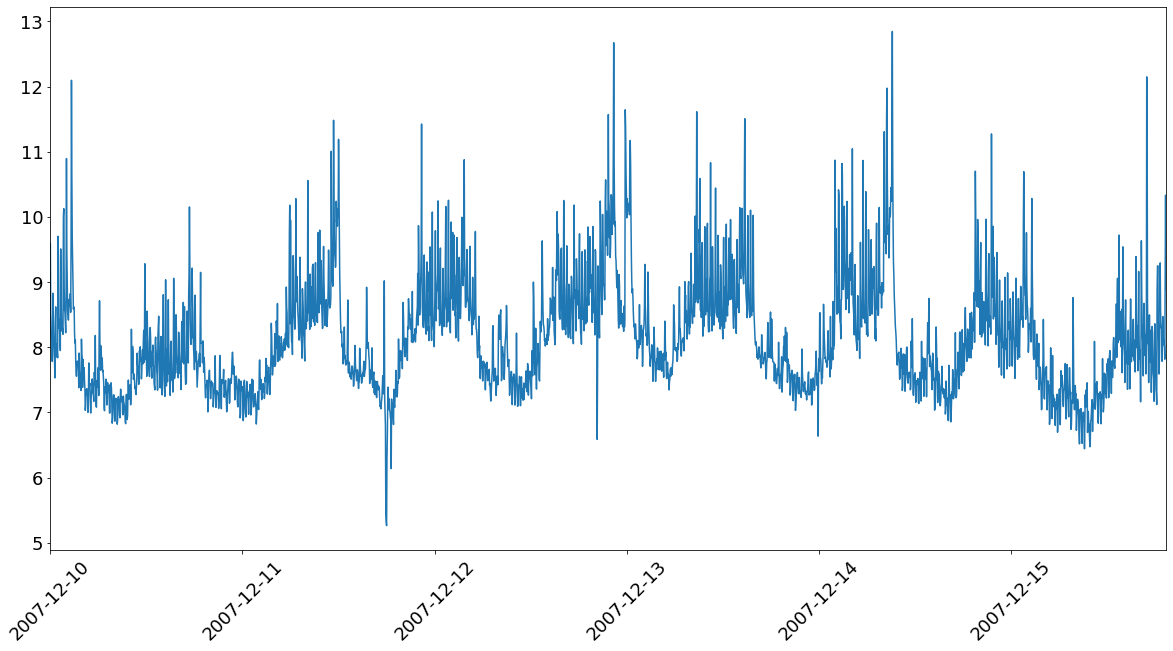

In [4]:
ax = df.y.plot(rot="45")
_ = ax.set_xticklabels(df.ds)

The second dataset shoes hourly Megawatt Energy Consumption.

In [5]:
pjme_df = pd.read_csv('PJME_hourly.csv') 
pjme_df.columns = ["ds", "y"]
pjme_df.head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


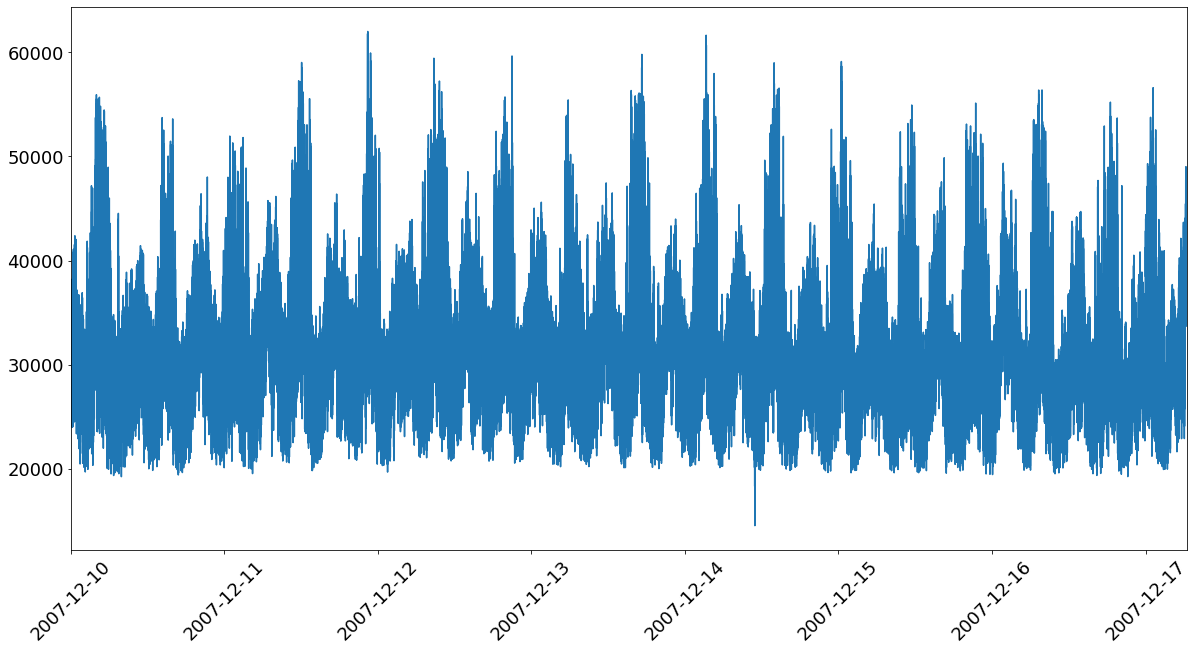

In [6]:
ax = pjme_df.y.plot(rot="45")
_ = ax.set_xticklabels(df.ds)

In [43]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [7]:
def get_train_test(data, window_size, starting_from):
    train_df = data.iloc[:-(window_size + starting_from), :]
    test_df = data.iloc[-(window_size + starting_from):(len(data)-starting_from), :]
    
    return train_df, test_df

In [8]:
def prophet_eval_function(train_df, test_df):
    m = Prophet(daily_seasonality=False)
    m.fit(train_df)
    forecast = m.predict(test_df.ds.to_frame())
    return forecast.yhat

In [31]:
def evaluate_time_series_data_on_model(df, model_eval_function, number_of_cutoffs=100, window_size = 7):
    cutoffs_points = list(range(0, number_of_cutoffs))
    cutoffs_points.reverse()
    all_forecasts = pd.Series([], name="yhat")
    all_actuals = pd.Series([], name="y")
    for cutoff in tqdm_notebook(cutoffs_points):
        train_df, test_df = get_train_test(df, window_size, cutoff)

        forecast = model_eval_function(train_df, test_df)
        all_forecasts = all_forecasts.append(forecast, ignore_index=True)
        all_actuals = all_actuals.append(test_df.y, ignore_index=True)

    mse = metrics.mean_squared_error(all_actuals, all_forecasts)
    return mse, all_actuals, all_forecasts

In [138]:
number_of_cutoffs = 280
window_size = 7

mse_prophet, all_actuals_prophet, all_forecasts_prophet = evaluate_time_series_data_on_model(df, prophet_eval_function, number_of_cutoffs, window_size)

mae_prophet = metrics.mean_absolute_error(y_true=all_actuals_prophet, y_pred=all_forecasts_prophet)
mape_prophet = mean_absolute_percentage_error(y_true=all_actuals_prophet, y_pred=all_forecasts_prophet)

print("Results on wp_log_peyton_manning dataset: ")
print(f"Prophet MSE: {mse_prophet}")
print(f"Prophet MAE: {mae_prophet}")
print(f"Prophet MAPE: {mape_prophet}")


Results on wp_log_peyton_manning dataset: 
Prophet MSE: 0.23048192399871745
Prophet MAE: 0.29098988768397455
Prophet MAPE: 3.6084857016947933


The results above are for a multi-step prediction (7 days prediction in the future).
Below is the plot.

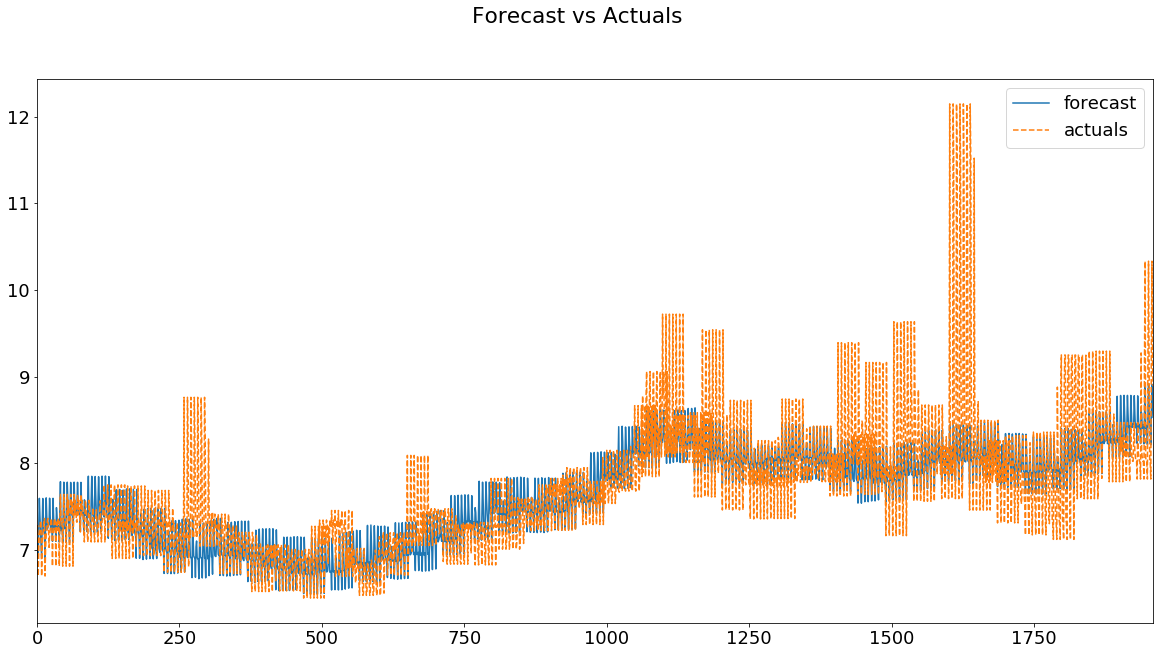

In [139]:
f, ax = pyplot.subplots(1)
data_for_plot = pd.DataFrame({"forecast": all_forecasts_prophet, "actuals": all_actuals_prophet})
_ = data_for_plot.plot(ax=ax, style=['-','--'])
plot = pyplot.suptitle('Forecast vs Actuals')

Let's now treat as if it was a single day prediction, by sampling only prediction multiple of 7.

In [143]:
sinple_step_indexes = list(range(0, len(all_forecasts_prophet), 7))
sinple_step_forecasts_prophet = all_forecasts_prophet[sinple_step_indexes]
sinple_step_actuals_prophet = all_actuals_prophet[sinple_step_indexes]

In [148]:
mse_ss_prophet = metrics.mean_squared_error(y_true=sinple_step_actuals_prophet, y_pred=sinple_step_forecasts_prophet)
mae_ss_prophet = metrics.mean_absolute_error(y_true=sinple_step_actuals_prophet, y_pred=sinple_step_forecasts_prophet)
mape_ss_prophet = mean_absolute_percentage_error(y_true=sinple_step_actuals_prophet, y_pred=sinple_step_forecasts_prophet)

print("Results on single step wp_log_peyton_manning dataset: ")
print(f"Prophet MSE: {mse_ss_prophet}")
print(f"Prophet MAE: {mae_ss_prophet}")
print(f"Prophet MAPE: {mape_ss_prophet}")

Results on single step wp_log_peyton_manning dataset: 
Prophet MSE: 0.2233080601431166
Prophet MAE: 0.2848430207257695
Prophet MAPE: 3.544358925843668


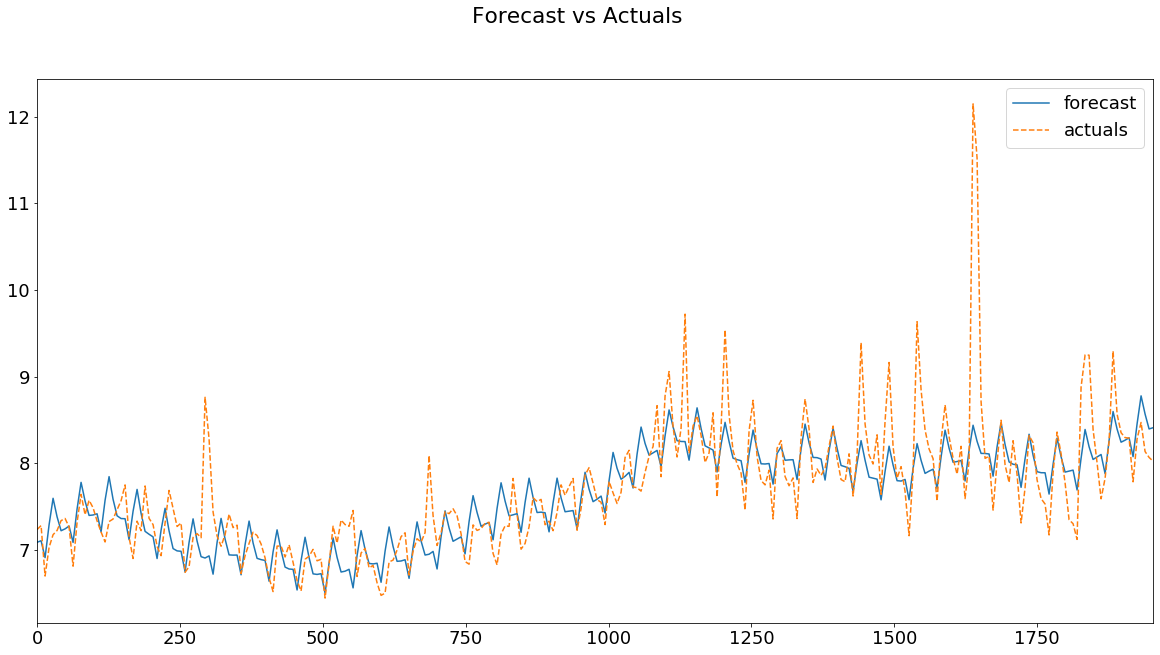

In [149]:
f, ax = pyplot.subplots(1)
data_for_plot = pd.DataFrame({"forecast": sinple_step_forecasts_prophet, "actuals": sinple_step_actuals_prophet})
_ = data_for_plot.plot(ax=ax, style=['-','--'])
plot = pyplot.suptitle('Forecast vs Actuals')

Let's try on the energy consumption dataset

In [21]:
def prophet_eval_function_with_daily_seasonality(train_df, test_df):
    m = Prophet()
    m.fit(train_df)
    forecast = m.predict(test_df.ds.to_frame())
    return forecast.yhat

In [23]:
mse_prophet, all_actuals_prophet, all_forecasts_prophet = evaluate_time_series_data_on_model(pjme_df, prophet_eval_function_with_daily_seasonality, number_of_cutoffs, window_size=24)

print(f"Prophet MSE: {mse_prophet} (Energy consumption dataset)")

SystemError: <class 'stanfit4anon_model_861b75c6337e237650a61ae58c4385ef_2657952942925697593.PyStanHolder'> returned a result with an error set

In [ ]:
mrse_prophet = metrics.mean_squared_error(y_true=all_actuals_prophet, y_pred=all_forecasts_prophet)
mape_prophet = mean_absolute_percentage_error(y_true=all_actuals_prophet, y_pred=all_forecasts_prophet):
print(f"Prophet MRSE: {xmrse_xgb}")
print(f"Prophet MAPE: {mape_prophet}")

### Let's now try XGBoost

In [11]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [12]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    time_seriers = pd.to_datetime(df['ds'])
    data_dict = {
        'dayofweek': time_seriers.dt.dayofweek,
        'quarter': time_seriers.dt.quarter,
        'month': time_seriers.dt.month,
        'year': time_seriers.dt.year,
        'dayofyear': time_seriers.dt.dayofyear,
        'dayofmonth': time_seriers.dt.day,
        'weekofyear': time_seriers.dt.weekofyear}
    
    return pd.DataFrame(data_dict)

In [13]:
create_features(df)

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,0,4,12,2007,344,10,50
1,1,4,12,2007,345,11,50
2,2,4,12,2007,346,12,50
3,3,4,12,2007,347,13,50
4,4,4,12,2007,348,14,50
...,...,...,...,...,...,...,...
2900,5,1,1,2016,16,16,2
2901,6,1,1,2016,17,17,2
2902,0,1,1,2016,18,18,3
2903,1,1,1,2016,19,19,3


In [14]:
def xgb_eval_function(train_df, test_df):
    X_train = create_features(train_df)
    y_train = train_df['y']
    
    reg = xgb.XGBRegressor(n_estimators=1000, max_depth = 5, objective ='reg:squarederror')
    _ = reg.fit(X_train, y_train, verbose=False) # Change verbose to True if you want to see it train
    
    X_test = create_features(test_df)

    forecast = reg.predict(X_test)
    return pd.Series(forecast)

In [32]:
mse_xgb, all_actuals, all_forecasts = evaluate_time_series_data_on_model(df, xgb_eval_function, number_of_cutoffs, window_size)
print(f"XGBoost MSE: {mse_xgb}")


XGBoost MSE: 0.6314002541637954


/Users/maccheroni/.virtualenvs/sandbox/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/Users/maccheroni/.virtualenvs/sandbox/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



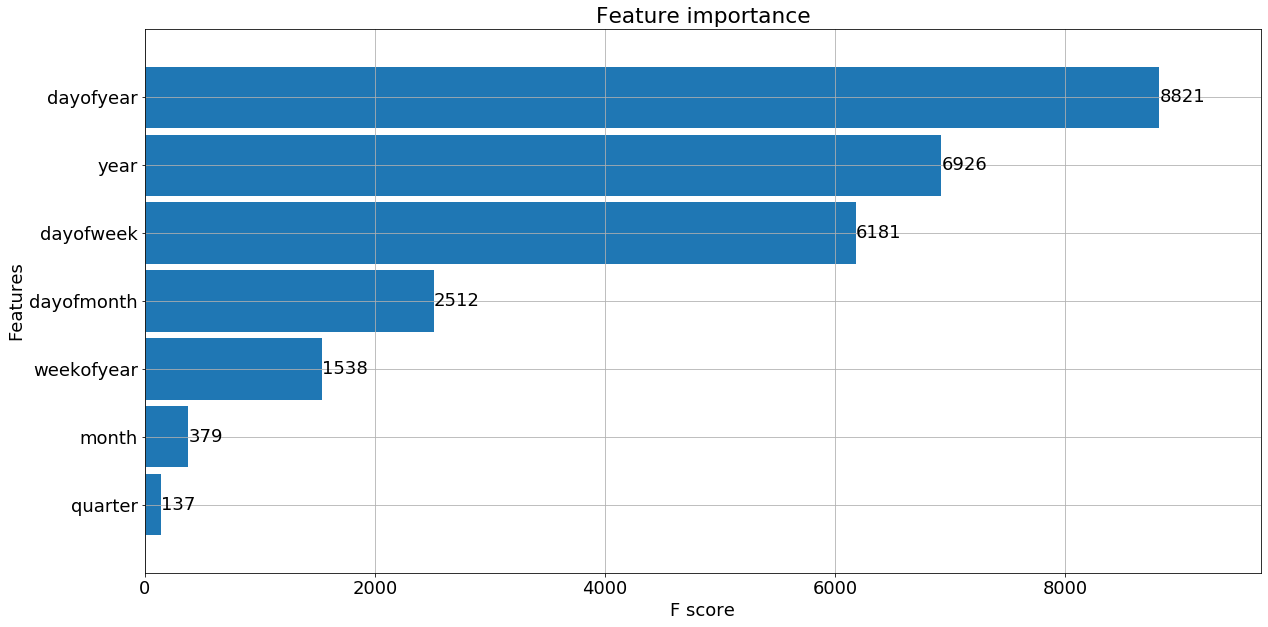

In [26]:
X_train = create_features(df)
y_train = df['y']

reg = xgb.XGBRegressor(n_estimators=1000, max_depth = 5, objective ='reg:squarederror')
_ = reg.fit(X_train, y_train, verbose=False) # Change verbose to True if you want to see it train
    
_ = plot_importance(reg, height=0.9)

Plot the forecast with the actuals

In [29]:
forecast = reg.predict(X_train)

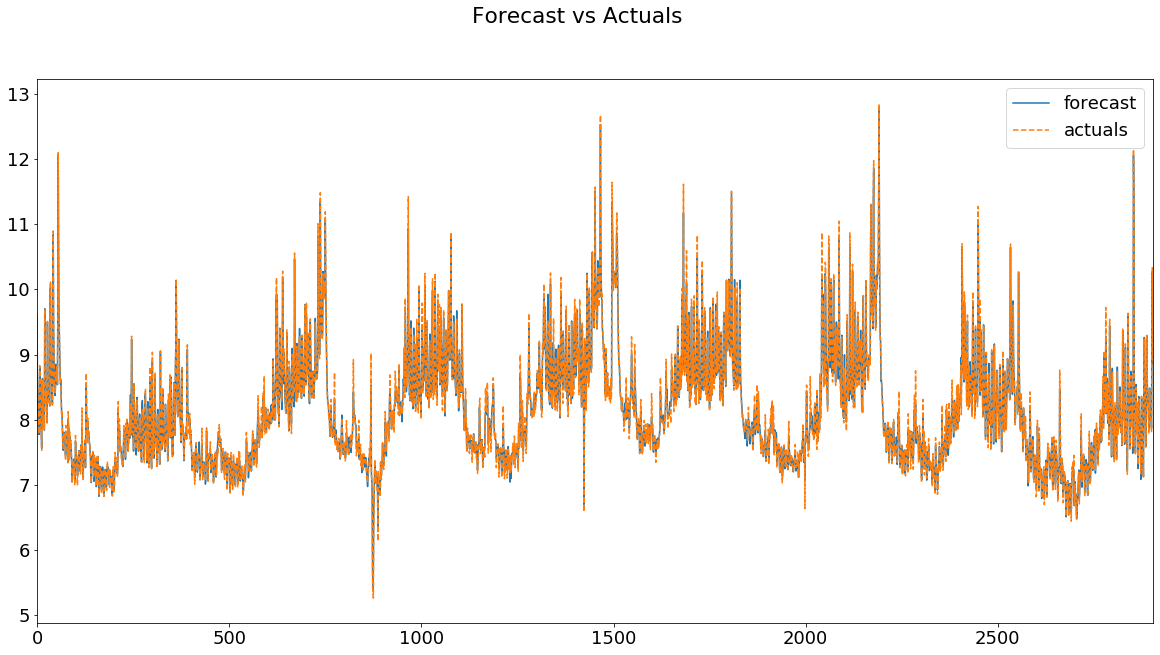

In [30]:
f, ax = pyplot.subplots(1)
data_for_plot = pd.DataFrame({"forecast": forecast, "actuals": y_train})
_ = data_for_plot.plot(ax=ax, style=['-','--'])
plot = pyplot.suptitle('Forecast vs Actuals')

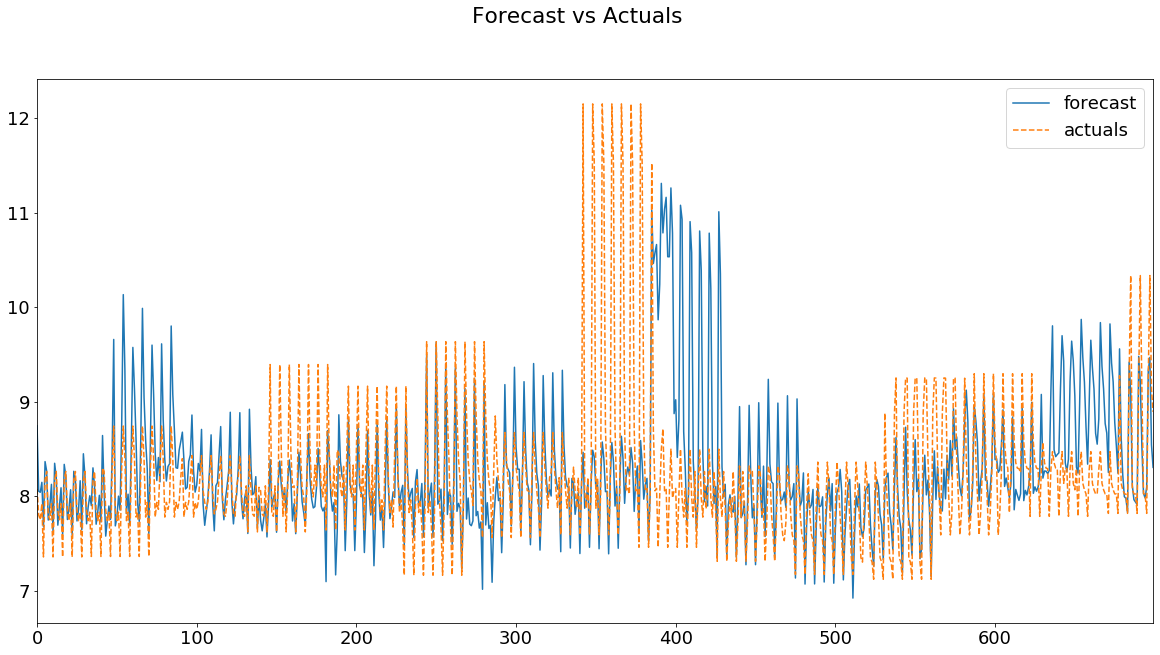

In [33]:
f, ax = pyplot.subplots(1)
data_for_plot = pd.DataFrame({"forecast": all_forecasts, "actuals": all_actuals})
_ = data_for_plot.plot(ax=ax, style=['-','--'])
plot = pyplot.suptitle('Forecast vs Actuals')

There is a bit of overfitting...  need to tune the parameters...

In [35]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    time_seriers = pd.to_datetime(df['ds'])
    data_dict = {
        'hour': time_seriers.dt.hour,
        'dayofweek': time_seriers.dt.dayofweek,
        'quarter': time_seriers.dt.quarter,
        'month': time_seriers.dt.month,
        'year': time_seriers.dt.year,
        'dayofyear': time_seriers.dt.dayofyear,
        'dayofmonth': time_seriers.dt.day,
        'weekofyear': time_seriers.dt.weekofyear}
    
    return pd.DataFrame(data_dict)

def xgb_eval_function(train_df, test_df):
    X_train = create_features(train_df)
    y_train = train_df['y']
    
    reg = xgb.XGBRegressor(n_estimators=1000, max_depth = 5, objective ='reg:squarederror')
    _ = reg.fit(X_train, y_train, verbose=False) # Change verbose to True if you want to see it train
    
    X_test = create_features(test_df)

    forecast = reg.predict(X_test)
    return pd.Series(forecast)

In [45]:
mse_xgb, all_actuals, all_forecasts = evaluate_time_series_data_on_model(pjme_df, xgb_eval_function, number_of_cutoffs, window_size=24)
mrse_xgb = metrics.mean_absolute_error(y_true=all_actuals, y_pred=all_forecasts)
mape_xgb = mean_absolute_percentage_error(y_true=all_actuals, y_pred=all_forecasts)
print(f"XGBoost MRSE: {mse_xgb}  (Energy consumption dataset)")
print(f"XGBoost MSE: {mrse_xgb}  (Energy consumption dataset)")
print(f"XGBoost MAPE: {mape_xgb} (Energy consumption dataset)")

XGBoost MRSE: 8361356.41826887  (Energy consumption dataset)
XGBoost MSE: 2469.0573185221356  (Energy consumption dataset)
XGBoost MAPE: 5.946146948700321 (Energy consumption dataset)


## LSTM for time series prediction
Here I will use a keras Stacked LSTM model for single-step and multi-step (predicting one step or more than one step in the future), univariate time series forecasting. Tutorial [here](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/).

#### Multi-Step

In [58]:
# univariate data preparation
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
 
# choose a number of time steps
n_steps_in, n_steps_out = 50, 7
# split into samples
X, y = split_sequence(df.y, n_steps_in, n_steps_out)
# summarize the data
# for i in range(len(X)):
#     print(X[i], y[i])

The LSTMs is for univariate data (the time series is one value), hence the prepared samples must first be reshaped. The LSTM expects data to have a three-dimensional structure of [samples, timesteps, features], and in this case, we only have one feature so the reshape is straightforward.

In [60]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

With the number of input and output steps specified in the n_steps_in and n_steps_out variables, we can define a multi-step time-series forecasting model.

Below defines a Stacked LSTM for multi-step forecasting.

In [67]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import LSTM
from sklearn.model_selection import train_test_split

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [86]:
X_test.shape

(285, 50, 1)

In [87]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

train the model

In [89]:
# fit model
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
2564/2564 [==============================] - 4s 2ms/step - loss: 0.4952
Epoch 2/50
2564/2564 [==============================] - 4s 2ms/step - loss: 0.3953
Epoch 3/50
2564/2564 [==============================] - 4s 2ms/step - loss: 0.3904
Epoch 4/50
2564/2564 [==============================] - 4s 2ms/step - loss: 0.3212
Epoch 5/50
2564/2564 [==============================] - 4s 2ms/step - loss: 0.3322
Epoch 6/50
2564/2564 [==============================] - 5s 2ms/step - loss: 0.3064
Epoch 7/50
2564/2564 [==============================] - 4s 2ms/step - loss: 0.3137
Epoch 8/50
2564/2564 [==============================] - 5s 2ms/step - loss: 0.2950
Epoch 9/50
2564/2564 [==============================] - 4s 2ms/step - loss: 0.3065
Epoch 10/50
2564/2564 [==============================] - 4s 2ms/step - loss: 0.2971
Epoch 11/50
2564/2564 [==============================] - 5s 2ms/step - loss: 0.2990
Epoch 12/50
2564/2564 [==============================] - 4s 2ms/step - loss: 0.2951
E

In [90]:
lstm_predictions = model.predict(X_test, verbose=0)

In [101]:
mse_lstm = metrics.mean_squared_error(y_true=y_test.ravel(), y_pred=lstm_predictions.ravel())
mrse_lstm = metrics.mean_absolute_error(y_true=y_test.ravel(), y_pred=lstm_predictions.ravel())
mape_lstm = mean_absolute_percentage_error(y_true=y_test.ravel(), y_pred=lstm_predictions.ravel())
print("Results on wp_log_peyton_manning dataset: ")
print(f"Multi-step LSTM MSE: {mse_lstm}")
print(f"Multi-step LSTM MRSE: {mrse_lstm}")
print(f"Multi-step LSTM MAPE: {mape_lstm}")

Results on wp_log_peyton_manning dataset: 
Multi-step LSTM MSE: 0.2803143686288678
Multi-step LSTM MRSE: 0.36979846786230786
Multi-step LSTM MAPE: 4.7040703869505345


#### Single-step

data preparation:

In [102]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [119]:
n_steps = 50
# split into samples
X, y = split_sequence(df.y, n_steps)

In [120]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [116]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [128]:
# fit model
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
2569/2569 [==============================] - 3s 1ms/step - loss: 6.0055
Epoch 2/100
2569/2569 [==============================] - 3s 1ms/step - loss: 0.2735
Epoch 3/100
2569/2569 [==============================] - 3s 1ms/step - loss: 0.2646
Epoch 4/100
2569/2569 [==============================] - 3s 1ms/step - loss: 0.2404
Epoch 5/100
2569/2569 [==============================] - 3s 1ms/step - loss: 0.2578
Epoch 6/100
2569/2569 [==============================] - 3s 1ms/step - loss: 0.2269
Epoch 7/100
2569/2569 [==============================] - 3s 1ms/step - loss: 0.2335
Epoch 8/100
2569/2569 [==============================] - 3s 1ms/step - loss: 0.2153
Epoch 9/100
2569/2569 [==============================] - 3s 1ms/step - loss: 0.2146
Epoch 10/100
2569/2569 [==============================] - 3s 1ms/step - loss: 0.2019
Epoch 11/100
2569/2569 [==============================] - 3s 1ms/step - loss: 0.2061
Epoch 12/100
2569/2569 [==============================] - 3s 1ms/step - lo

2569/2569 [==============================] - 3s 1ms/step - loss: 0.1427
Epoch 98/100
2569/2569 [==============================] - 4s 1ms/step - loss: 0.1403
Epoch 99/100
2569/2569 [==============================] - 3s 1ms/step - loss: 0.1496
Epoch 100/100
2569/2569 [==============================] - 3s 1ms/step - loss: 0.1526


In [129]:
lstm_predictions = model.predict(X_test, verbose=0)

In [135]:
mse_lstm = metrics.mean_squared_error(y_true=y_test, y_pred=lstm_predictions.ravel())
mrse_lstm = metrics.mean_absolute_error(y_true=y_test, y_pred=lstm_predictions.ravel())
mape_lstm = mean_absolute_percentage_error(y_true=y_test, y_pred=lstm_predictions.ravel())
print("Results on wp_log_peyton_manning dataset: ")
print(f"Multi-step LSTM MSE: {mse_lstm}")
print(f"Multi-step LSTM MRSE: {mrse_lstm}")
print(f"Multi-step LSTM MAPE: {mape_lstm}")

Results on wp_log_peyton_manning dataset: 
Multi-step LSTM MSE: 0.18790071115143742
Multi-step LSTM MRSE: 0.2603863091809982
Multi-step LSTM MAPE: 3.208224684173126


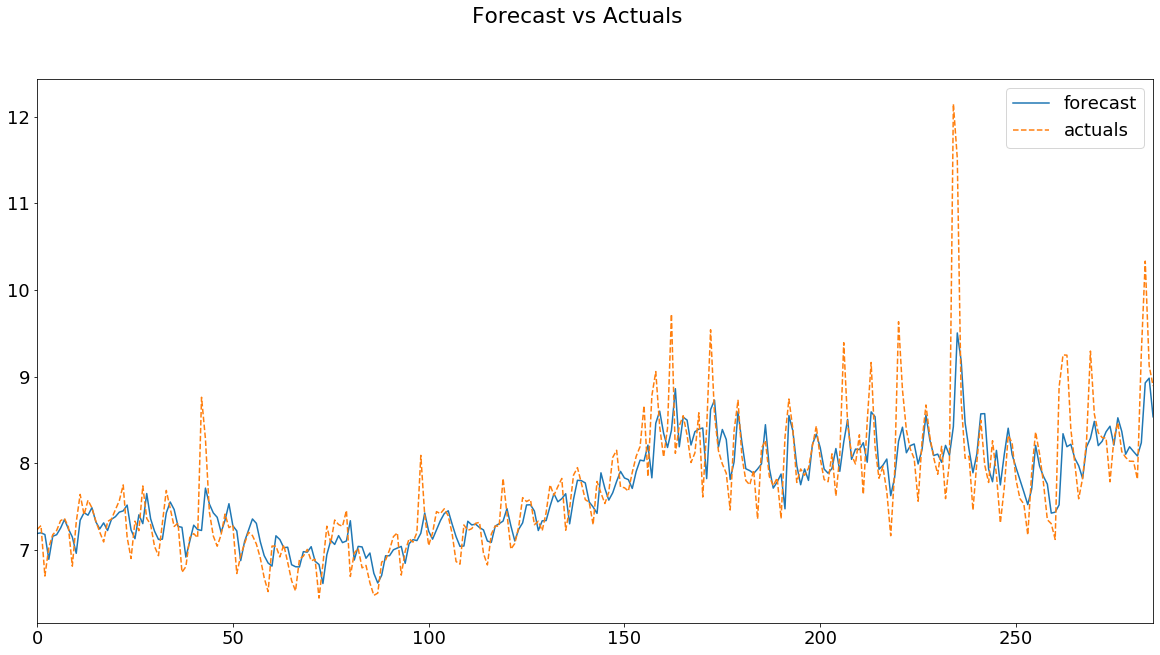

In [136]:
f, ax = pyplot.subplots(1)
data_for_plot = pd.DataFrame({"forecast": lstm_predictions.ravel(), "actuals": y_test})
_ = data_for_plot.plot(ax=ax, style=['-','--'])
plot = pyplot.suptitle('Forecast vs Actuals')

This looks pretty fucking cool...